# Importing the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings

In [2]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/MRI_Dataset.zip'
extraction_path = 'data/extracted_files'

# Check if the extraction path exists, if not, create it
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

extracted_files = os.listdir(extraction_path)
extracted_files


['Data']

In [3]:
# Define paths
source_folder = os.path.join('data', 'extracted_files', 'Data')
target_folder = 'Brain_tumor_dataset'

# Check if the source folder exists
if not os.path.exists(source_folder):
    print(f"Source folder not found: {source_folder}")
    raise FileNotFoundError(f"Source folder not found: {source_folder}")


In [4]:
# Define labels and their mapped names
labels = ['Normal', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
mapped_labels = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Create target folders for training and testing
for phase in ['training', 'testing']:
    for label in mapped_labels:
        os.makedirs(os.path.join(target_folder, phase, label), exist_ok=True)



In [5]:
# Function to copy images to the new folder structure
def copy_images_to_folder(image_paths, destination_folder):
    for img_path in image_paths:
        label = os.path.basename(os.path.dirname(img_path))
        if label == 'Normal':
            label = 'no_tumor'  # Rename 'Normal' to 'no_tumor' for consistency
        dest_path = os.path.join(destination_folder, label, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

# Function to load and sample images
def load_and_sample_images(folder_path, label, target_label):
    image_list = []
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid image files
                image_list.append(os.path.join(folder_path, filename))

        # Randomly sample a portion of the images
        sampled_images = random.sample(image_list, len(image_list) // 5)
        return [(img_path, target_label) for img_path in sampled_images]
    else:
        print(f"Folder not found: {folder_path}")
        return []



In [6]:
import random
# Collect and sample images
all_images_and_labels = []
all_images_and_labels.extend(load_and_sample_images(os.path.join(source_folder, 'Normal'), 'Normal', 'no_tumor'))

for label in ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']:
    all_images_and_labels.extend(load_and_sample_images(os.path.join(source_folder, 'Tumor', label), label, label))

# Separate images and labels
all_images = [item[0] for item in all_images_and_labels]
all_labels = [item[1] for item in all_images_and_labels]


In [ ]:

import shutil
# Split data into training (60%) and testing (40%) sets
train_images, test_images, _, _ = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)

# Copy images to respective training and testing folders
copy_images_to_folder(train_images, os.path.join(target_folder, 'training'))
copy_images_to_folder(test_images, os.path.join(target_folder, 'testing'))

print("Data split and copied successfully!")



Data split and copied successfully!


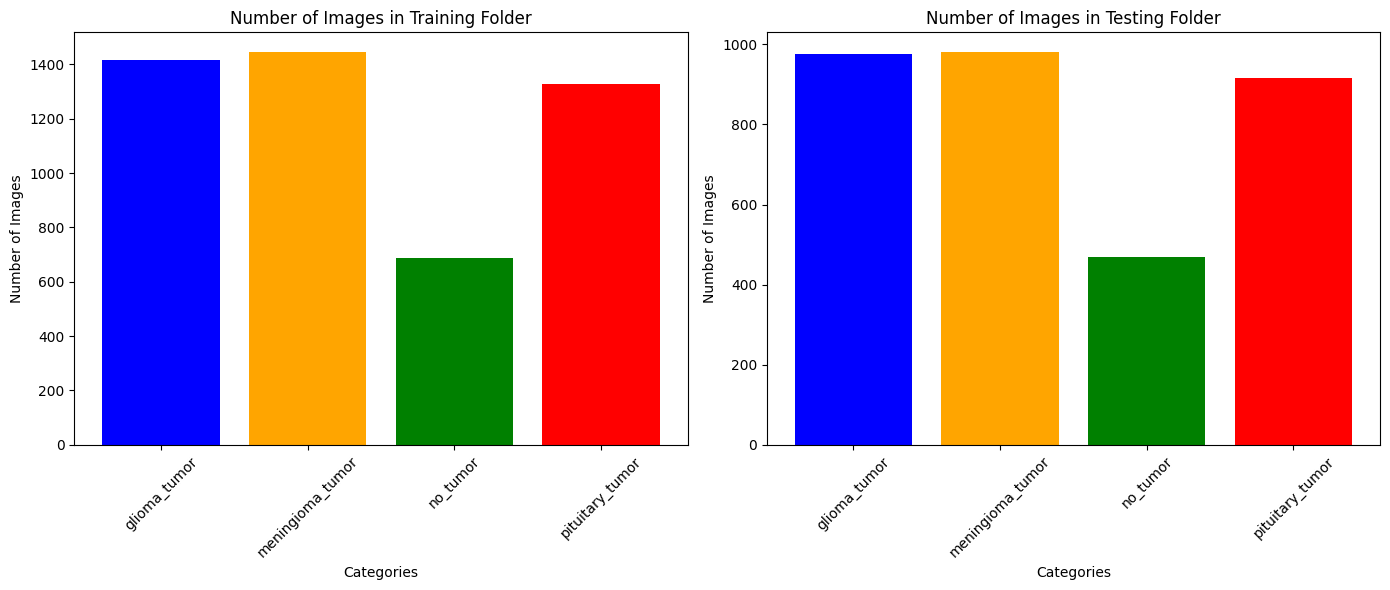

In [8]:
# Define paths for the training and testing directories
base_dir = 'Brain_tumor_dataset'
subdirs = ['training', 'testing']
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Function to count the number of images in each subdirectory
def count_images_in_folders(base_path, labels):
    counts = {}
    for label in labels:
        folder_path = os.path.join(base_path, label)
        if os.path.exists(folder_path):
            counts[label] = len([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        else:
            counts[label] = 0
    return counts

# Count images for both training and testing folders
image_counts = {subdir: count_images_in_folders(os.path.join(base_dir, subdir), labels) for subdir in subdirs}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, subdir in enumerate(subdirs):
    counts = image_counts[subdir]
    axes[i].bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
    axes[i].set_title(f'Number of Images in {subdir.capitalize()} Folder')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Number of Images')
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
#image loading, resizing, and labeling for both training and testing datasets.
x_train = [] # MRI image
y_train = [] # Label of the image
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


image_size = 256
for i in labels:
    folderPath = os.path.join('/content/Brain_tumor_dataset/training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        x_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Brain_tumor_dataset/testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        x_train.append(img)
        y_train.append(i)

x_train = np.array(x_train)
y_train = np.array(y_train)

100%|██████████| 915/915 [00:01<00:00, 891.56it/s]


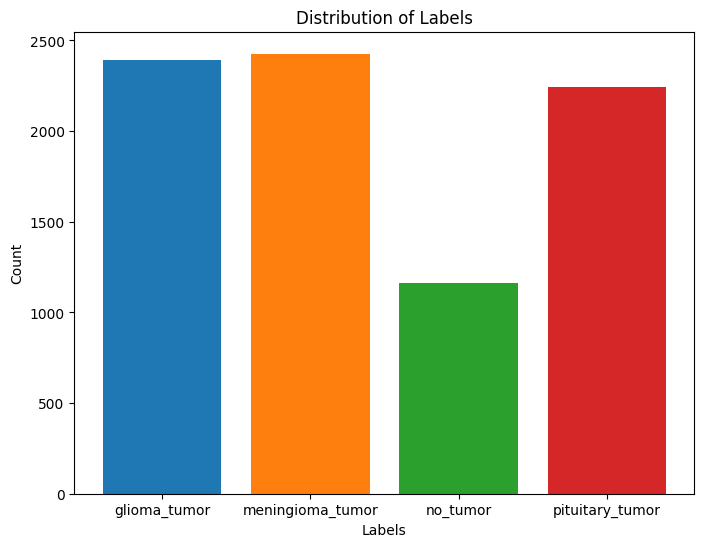

In [10]:

# Use a compressed for loop to create a object of the label and the count
label_counts = {label: np.sum(y_train == label) for label in labels}

# Stretch the graph
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

plt.show()

In [11]:

# Convert the label to one-hot encoding format which converts the categorical data to numeric one
y_train = np.array(pd.get_dummies(y_train))

print(y_train)

[[ True False False False]
 [ True False False False]
 [ True False False False]
 ...
 [False False False  True]
 [False False False  True]
 [False False False  True]]


In [15]:

#Split the dataset into training, testing and validation sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2,random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'X_train shape: {(x_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(x_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_valid shape: {(x_valid).shape}\n'
      f'y_valid shape: {(y_valid).shape}')

X_train shape: (1377, 256, 256, 3)
y_train shape: (1377, 4)
X_test shape: (431, 256, 256, 3)
y_test shape: (431, 4)
X_valid shape: (345, 256, 256, 3)
y_valid shape: (345, 4)


In [ ]:
# Normalize pixel values of training images to the range [0,1]
#improves convergence
x_train = x_train / 255

print(f"Maximum and Minimum pixel value after normalization: {x_train.min()} - {x_train.max()}")


Maximum and Minimum pixel value after normalization: 0.0 - 1.0


In [17]:
x_test = x_test / 255


In [18]:
x_valid = x_valid / 255

In [19]:
# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

# Hidden layer
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.45))

# Output layer
model.add(Dense(4, activation='softmax'))

# Model Config
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,364 (8.18 MB)

 Trainable params: 2,143,364 (8.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model with a smaller batch size
start_time = time.time()

history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=45,
    batch_size=32,
    verbose=1
)


Epoch 1/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.3451 - loss: 1.3681 - val_accuracy: 0.4377 - val_loss: 1.2869
Epoch 2/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4598 - loss: 1.2205 - val_accuracy: 0.4928 - val_loss: 1.1208
Epoch 3/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5654 - loss: 1.0098 - val_accuracy: 0.5884 - val_loss: 1.0187
Epoch 4/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6024 - loss: 0.9220 - val_accuracy: 0.6087 - val_loss: 0.9590
Epoch 5/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5940 - loss: 0.9302 - val_accuracy: 0.6261 - val_loss: 0.8949
Epoch 6/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6322 - loss: 0.8458 - val_accuracy: 0.6406 - val_loss: 0.8413
Epoch 7/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.6856 - loss: 0.7361 - val_accuracy: 0.6609 - val_loss: 0.7996
Epoch 8/45
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6877 - loss: 0.7267 - val_accuracy: 0.6725 -

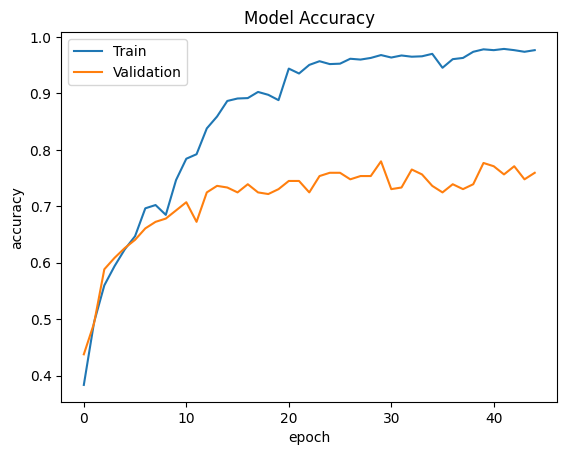

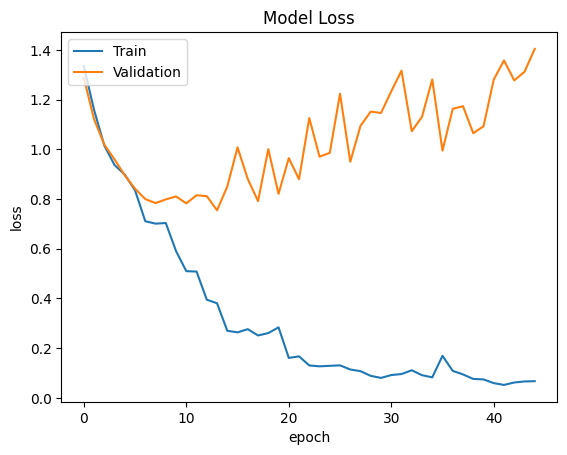

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


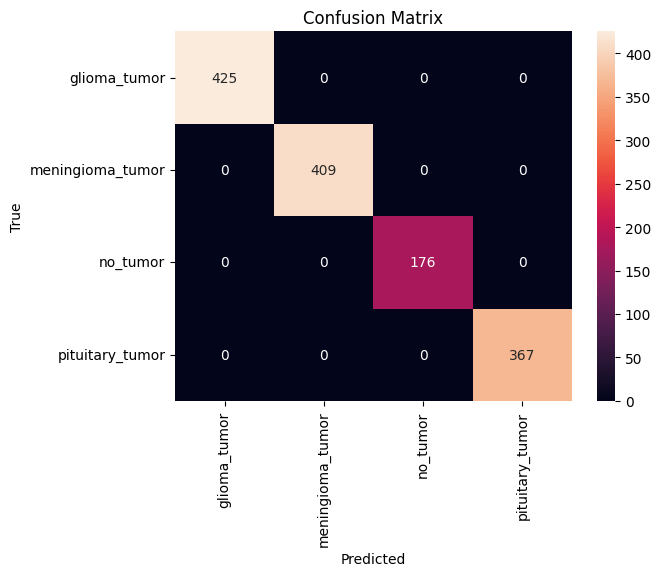

In [22]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


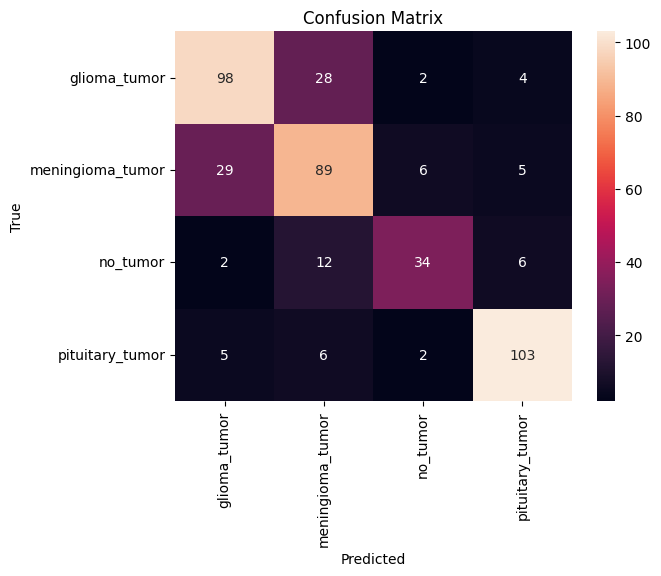

In [23]:

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



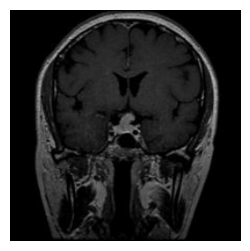

In [25]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 100.00%



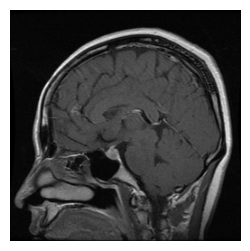

In [28]:
img_path = '/content/data/extracted_files/Data/Tumor/pituitary_tumor/P_100.jpg'
custom_actual_label = 'pituitary_tumor'

custom_img_arr = []
tumor_img = cv2.imread(img_path)
tumor_img = cv2.resize(tumor_img, (256, 256))
custom_img_arr.append(tumor_img)
custom_img_arr = np.array(custom_img_arr)
custom_img_arr = custom_img_arr / 255

custom_pred = model.predict(custom_img_arr.reshape(1, 256, 256, 3))

custom_pred_class = np.argmax(custom_pred)
custom_pred_label = labels[custom_pred_class]
custom_pred_confidence = custom_pred[0][custom_pred_class]

print(f"Predicted label: {custom_pred_label} \nActual label: {custom_actual_label} \nConfidence: {custom_pred_confidence*100:.2f}%\n")
plt.figure(figsize=(3, 3))
plt.imshow(tumor_img)
plt.axis('off')
plt.show()


# model 3 Resnet Model


In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional base to avoid retraining it
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Build the model
model_resnet50 = Sequential([
    Input(shape=(256, 256, 3)),
    base_model_resnet50,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])


# Display the model summary
model_resnet50.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,143,428 (217.98 MB)

 Trainable params: 33,555,716 (128.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
# Compile the model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [39]:
# Fit the ResNet50 model
history_resnet50 = model_resnet50.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    verbose=1
)


Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 433ms/step - accuracy: 0.3118 - loss: 3.6329 - val_accuracy: 0.3739 - val_loss: 1.3254
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.3425 - loss: 1.3273 - val_accuracy: 0.3826 - val_loss: 1.2936
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.3671 - loss: 1.2826 - val_accuracy: 0.4145 - val_loss: 1.2791
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.3185 - loss: 1.2915 - val_accuracy: 0.5275 - val_loss: 1.2348
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.3824 - loss: 1.2426 - val_accuracy: 0.3623 - val_loss: 1.2379
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.3816 - loss: 1.2611 - val_accuracy: 0.5333 - val_loss: 1.2157
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.3757 - loss: 1.2475 - val_accuracy: 0.5130 - val_loss: 1.2260
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.3817 - loss: 1.2535 - val_accurac

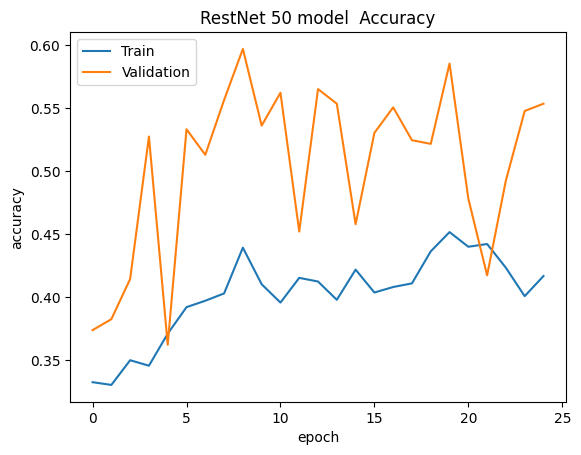

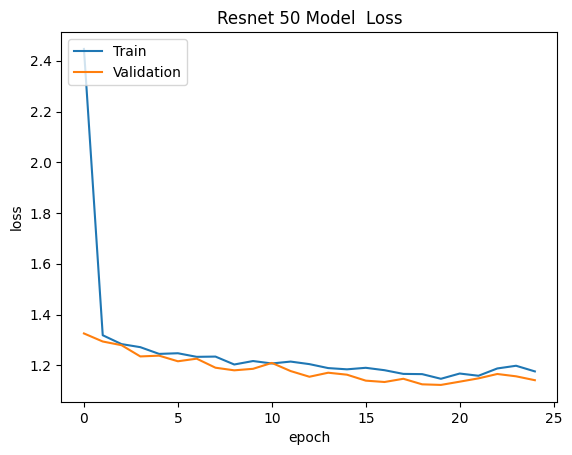

In [40]:
# summarize history for accuracy
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('RestNet 50 model  Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Resnet 50 Model  Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step


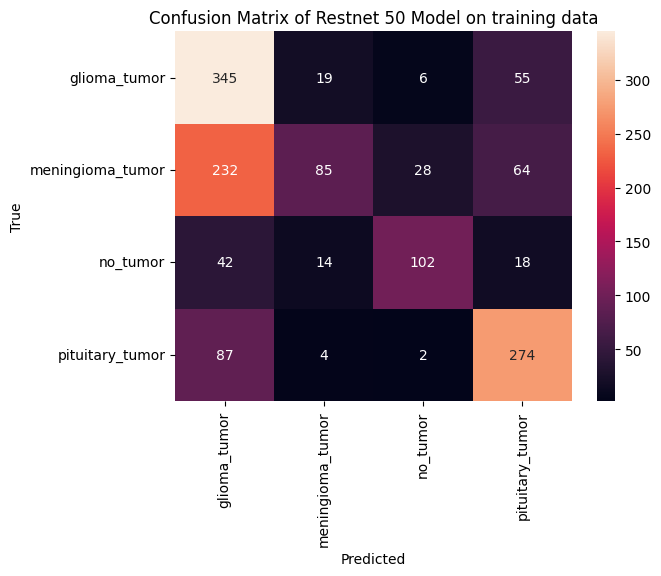

In [41]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_resnet50.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Restnet 50 Model on training data')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step


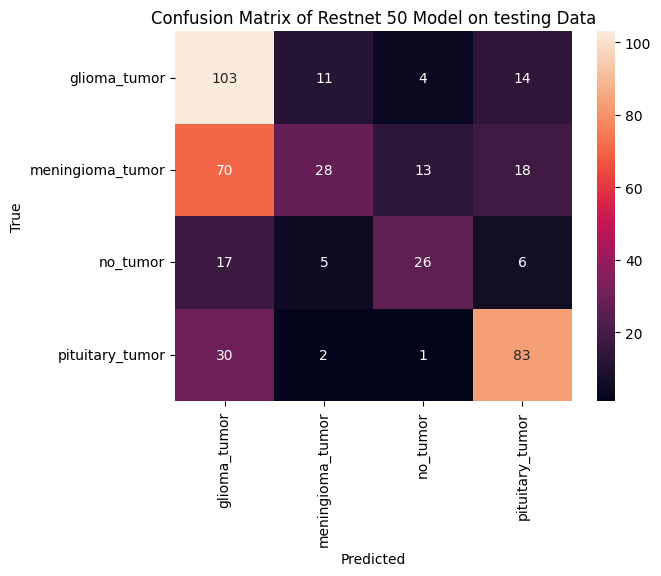

In [42]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_resnet50.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix of Restnet 50 Model on testing Data")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 42.33%



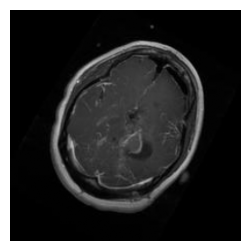

In [44]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model_resnet50.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

 # Model 4: VGG Model

In [45]:
from tensorflow.keras.applications import VGG19

base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))  # Use 224x224 input shape

# Freeze the convolutional base to avoid retraining it
for layer in base_model_vgg19.layers:
    layer.trainable = False

# Build the model
model_vgg19 = Sequential([
    Input(shape=(256, 256, 3)),
    base_model_vgg19,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model_vgg19.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg19.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,414,276 (108.39 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [46]:
# Fit the ResNet50 model
VGG_Model_history = model_vgg19.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=25,
    batch_size=32,
    verbose=1
)

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 806ms/step - accuracy: 0.3802 - loss: 1.5926 - val_accuracy: 0.6551 - val_loss: 0.9164
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 245ms/step - accuracy: 0.5895 - loss: 0.9752 - val_accuracy: 0.6870 - val_loss: 0.7996
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.6539 - loss: 0.8278 - val_accuracy: 0.6754 - val_loss: 0.7499
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.7213 - loss: 0.6844 - val_accuracy: 0.6696 - val_loss: 0.7621
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.6983 - loss: 0.7292 - val_accuracy: 0.7391 - val_loss: 0.6846
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.7811 - loss: 0.6073 - val_accuracy: 0.6841 - val_loss: 0.7199
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.7973 - loss: 0.5418 - val_accuracy: 0.6464 - val_loss: 0.8098
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 252ms/step - accuracy: 0.7161 - loss: 0.6649 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step


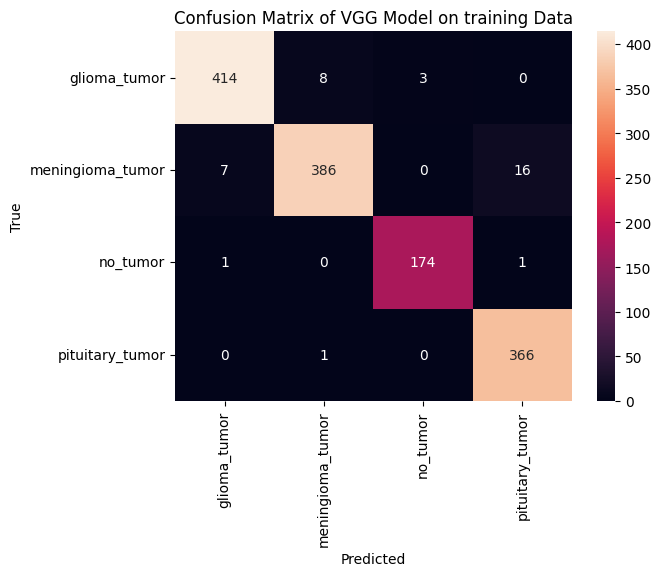

In [47]:
y_true = np.argmax(y_train, axis=1)
y_pred = np.argmax(model_vgg19.predict(x_train), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of VGG Model on training Data')
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


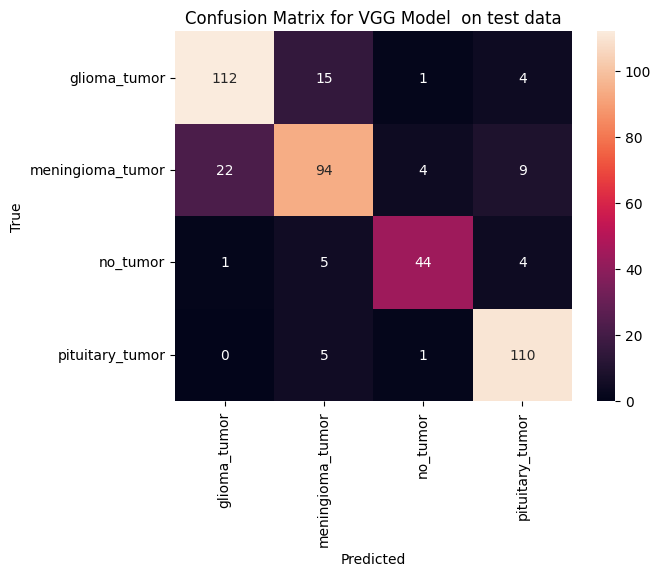

In [48]:

y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model_vgg19.predict(x_test), axis=1)

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG Model  on test data')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 97.65%



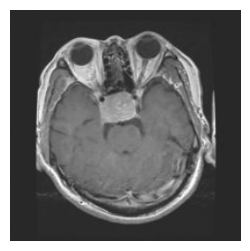

In [50]:
random_index = np.random.randint(0, len(x_test))
random_img = x_test[random_index]
predictions = model_vgg19.predict(random_img.reshape(1, 256, 256, 3))

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"Predicted label: {predicted_label} \nActual label: {actual_label} \nConfidence: {confidence*100:.2f}%\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()